# EN3160 - Image Assignment 2 - Fitting and Alignment

> Index No: 210610H

> Name : Sirimanna N.T.W.

## Question 1


### 1. Blob Detection Overview
Blob detection is a technique in computer vision that identifies regions in an image that differ in properties like brightness or color compared to their surroundings. In this task, we use the Laplacian of Gaussian (LoG) method and scale-space extrema detection to detect circular objects. This approach is useful for identifying circular blobs of varying sizes, such as sunflower heads in a field.

### 2. Laplacian of Gaussian (LoG) Method
The Laplacian of Gaussian (LoG) filter is designed to detect edges and spots in an image by convolving the image with a Gaussian function followed by the Laplacian operator. The Gaussian smoothing helps reduce noise, and the Laplacian operator identifies regions with rapid intensity changes, such as circular blobs.

The mathematical representation of LoG is:

\[
LoG(x, y) = \nabla^2 (G(x, y) * I(x, y))
\]

where \( G(x, y) \) is the Gaussian function and \( I(x, y) \) is the image.

In this task, applying the LoG method highlights circular regions, allowing us to detect sunflower heads.

### 3. Scale-Space Extrema Detection
To detect circles of various sizes, we use scale-space analysis, which involves examining the image at multiple scales by varying the standard deviation (\( \sigma \)) of the Gaussian. This allows the detection of blobs across different sizes.

The extrema (maxima or minima) in the scale space represent potential blobs. By identifying these extrema, we can find the optimal scale where each blob appears most prominent, giving us the radius of the circle.



Largest Circle Parameters:
Radius: 72.40773439350254
Center Coordinates (x, y): (98, 884)

Range of σ values used:
Minimum σ: 0.4
Maximum σ: 51.200000000000045



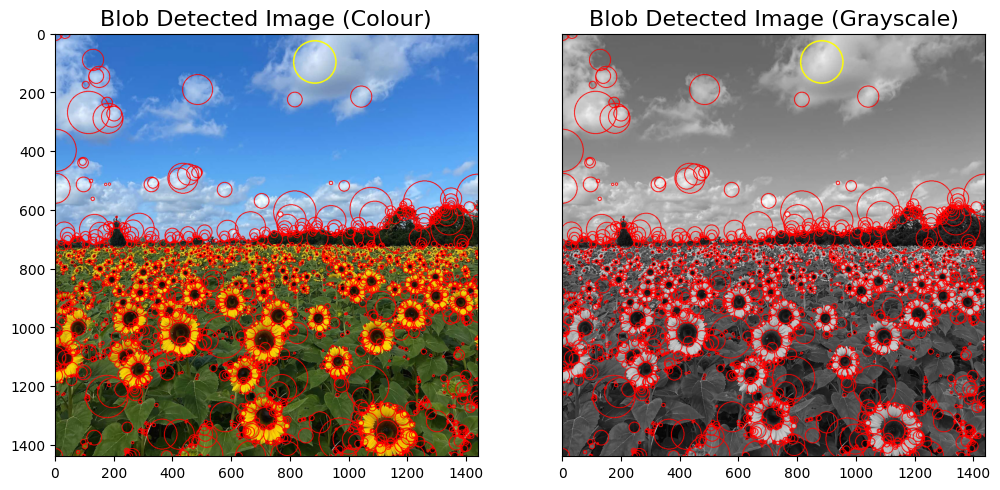

In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Function Definitions

def log_kernel(sigma, size):

        if size % 2 == 0:  # Size must be odd
                size = size + 1

        sigma2 = sigma ** 2  # Sigma squared
        idx_range = np.linspace(-(size - 1) / 2., (size - 1) / 2., size)  # Index range 
        x_idx, y_idx = np.meshgrid(idx_range, idx_range)  # Meshgrid of index range
        tmp_cal = -(np.square(x_idx) + np.square(y_idx)) / (2. * sigma2)  # Calculate the exponential term
        kernel = np.exp(tmp_cal)  # Computes the Gaussian kernel
        kernel[kernel < np.finfo(float).eps * np.amax(kernel)] = 0  # Discards very small numbers
        k_sum = np.sum(kernel)  # Sums all the elements in the kernel

        if k_sum != 0:
                kernel /= np.sum(kernel)  # Normalizes the kernel

        tmp_kernel = np.multiply(kernel, np.square(x_idx) + np.square(y_idx) - 2 * sigma2) / (sigma2 ** 2)  # Computes the Laplacian component of the LoG filter
        kernel = tmp_kernel - np.sum(tmp_kernel) / (size ** 2) # Final LoG filter
        return kernel

def show_kernel(kernel):
        plt.imshow(kernel, cmap='viridis')
        plt.colorbar()
        plt.title('Kernel')
        plt.show()



img = cv.imread("images/the_berry_farms_sunflower_field.jpeg")


gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY) # Convert to grayscale
gray = np.float32(gray) # Convert to float32
cv.normalize(gray, gray, 1, 0, cv.NORM_MINMAX) # Normalize the image

sigma0 = 0.4 # Initial sigma. Selected through trial and error to produce the best results
k = np.sqrt(2) # Scale factor
num_scales = 15 # Number of scales
sigmas = sigma0 * np.power(k, np.arange(num_scales)) # Array of sigma values for each scale


# LoG Filtering at Multiple Scales
img_stack = None

for i in range(num_scales):

        size = int(2 * np.ceil(4 * sigmas[i]) + 1) # Size of the kernel

        kernel = log_kernel(sigmas[i], size) * np.power(sigmas[i], 2) # LoG filter
        #show_kernel(kernel) # Display the kernel

        filtered = cv.filter2D(gray, cv.CV_32F, kernel) # Filter the image with the LoG filter
        filtered = pow(filtered, 2) # Square the filtered image
        
        # Filtered images are stored in img_stack
        if i == 0:  #
                img_stack = filtered 
        else:
                img_stack = np.dstack((img_stack, filtered)) 


# Maximum Response Extraction
scale_space = None 

for i in range(num_scales):
        filtered = cv.dilate(img_stack[:, :, i], np.ones((3, 3)), cv.CV_32F, (-1, -1), 1, cv.BORDER_CONSTANT) # Dilate the image
        
        # Filtered images are stored in scale_space
        if i == 0:
                scale_space = filtered
        else:
                scale_space = np.dstack((scale_space, filtered))


max_stack = np.amax(scale_space, axis=2)  # Find the maximum response across all the dilated images along the third axis (axis=2)
max_stack = np.repeat(max_stack[:, :, np.newaxis], num_scales, axis=2)  # Expand the 2D image into a 3D stack of identical 2D images, effectively replicating the maximum response image for each scale
max_stack = np.multiply((max_stack == scale_space), scale_space)  # Multiplies the 3D stack of images by a binary mask. The mask (max_stack == scale_space) will be 1 where the maximum response matches the original scale space and 0 elsewhere. This effectively retains only the maximum responses in the stack.


radius_vec = None
x_vec = None
y_vec = None


for i in range(num_scales):
        
        radius = np.sqrt(2) * sigmas[i] # Radius of the blob
        threshold = 0.01 # Threshold for the maximum response
        # filter out redundant response
        valid = (max_stack[:, :, i] == img_stack[:, :, i]) * img_stack[:, :, i] # Retains only the maximum responses in the stack
        valid[valid <= threshold] = 0 # Discards responses below the threshold
        (x, y) = np.nonzero(valid) # Finds the coordinates of the maximum responses
        
        if i == 1:
                x_vec = x # Creates a vector of the x coordinates of the maximum responses
                y_vec = y # Creates a vector of the y coordinates of the maximum responses               
                radius_vec = np.repeat(radius, np.size(x)) # Creates a vector of the radius of the blob
        else:
                x_vec = np.concatenate((x_vec, x), axis=None) # Concatenates the x coordinates of the maximum responses
                y_vec = np.concatenate((y_vec, y), axis=None) # Concatenates the y coordinates of the maximum responses
                tmp_vec = np.repeat(radius, np.size(x)) # Creates a vector of the radius of the blob
                radius_vec = np.concatenate((radius_vec, tmp_vec), axis=None) # Concatenates the radius vector


# Find the parameters of the largest circles
max_radius = np.max(radius_vec)
max_circle_idx = np.argmax(radius_vec)
max_x = x_vec[max_circle_idx]
max_y = y_vec[max_circle_idx]


# Report the parameters of the largest circles
print()
print(f"Largest Circle Parameters:")
print(f"Radius: {max_radius}")
print(f"Center Coordinates (x, y): ({max_x}, {max_y})")

# Report the range of σ values used
min_sigma = np.min(sigmas)
max_sigma = np.max(sigmas)
print(f"\nRange of σ values used:")
print(f"Minimum σ: {min_sigma}")
print(f"Maximum σ: {max_sigma}")
print()


out = cv.cvtColor(img, cv.COLOR_BGR2GRAY) 
out = cv.cvtColor(out, cv.COLOR_GRAY2BGR) 


out_colour    = img.copy()  
out_grayscale = out.copy()


for i in range(np.size(x_vec)):
        if i == max_circle_idx: 
                # Colour the largest circle in yellow
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)   
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0,255,255), 3)  
        else:
                # Colour the other circles in red
                cv.circle(out_colour, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  
                cv.circle(out_grayscale, (y_vec[i], x_vec[i]), int(radius_vec[i]), (0, 0, 255), 2)  

# Save the output images
cv.imwrite("Outputs/the_berry_farms_sunflower_field_blob_detected_COLOUR.jpeg", out_colour)
cv.imwrite("Outputs/the_berry_farms_sunflower_field_blob_detected_GRAY.jpeg", out_grayscale)


# Display the above images using matplot lib as subplots
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(cv.cvtColor(out_colour, cv.COLOR_BGR2RGB))
plt.title("Blob Detected Image (Colour)",fontsize=16)
plt.subplot(1,2,2)
plt.imshow(cv.cvtColor(out_grayscale,cv.COLOR_BGR2RGB), cmap='gray') 
plt.yticks([])
plt.title("Blob Detected Image (Grayscale)",fontsize=16)
plt.show()

## Question 2

Selected points: [[214, 442], [222, 164], [436, 483], [441, 290]]


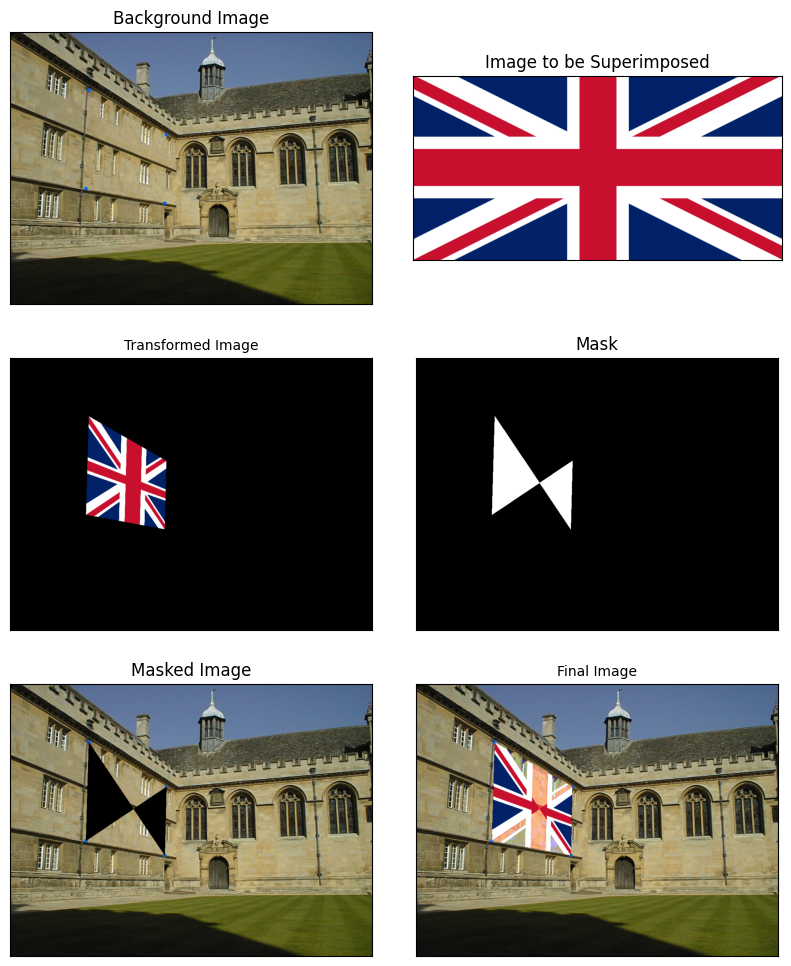

In [26]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def selecting_points(event, x, y, flags, param):
    global positions, count
    if event == cv.EVENT_LBUTTONUP:
        cv.circle(background_image, (x, y), 5, (255, 100, 0), -1)
        positions.append([x, y])
        count += 1

# Load images
background_image = cv.imread('images/005.jpg')
image_to_superimpose = cv.imread('images/flag.png')

# Initialize global variables
positions = []  # List to store selected coordinates
count = 0       # Number of points selected

cv.namedWindow('Select Points')  # Window to display the background image
cv.setMouseCallback('Select Points', selecting_points)

# Main loop to capture mouse clicks
while True:
    cv.imshow('Select Points', background_image)
    k = cv.waitKey(20)
    if k == 27:  # Escape key to exit
        break
    if len(positions) >= 4:  # Exit if 4 points have been selected
        print("Selected points:", positions[:4])
        break

cv.destroyAllWindows()

# Check if at least 4 points have been selected
if len(positions) < 4:
    print("Not enough points selected.")
    exit(1)

# Extract dimensions
height_background, width_background = background_image.shape[:2]
height_superimposing_image, width_superimposing_image = image_to_superimpose.shape[:2]

# Define source and destination points for homography
pts1 = np.float32([[0, 0], [width_superimposing_image, 0],
                   [0, height_superimposing_image], 
                   [width_superimposing_image, height_superimposing_image]])
pts2 = np.float32(positions[:4])

# Calculate the perspective transformation matrix
h, mask = cv.findHomography(pts1, pts2, cv.RANSAC, 5.0)

# Apply the perspective transformation
perspective_transformed_superimposing_image = cv.warpPerspective(image_to_superimpose, h, (width_background, height_background))

# Create a mask for the background image
background_mask = np.zeros(background_image.shape[:2], dtype=np.uint8)

# Define the region of interest using the selected positions
roi_points = np.array(positions[:4], dtype=np.int32)  # Use the first four selected points
cv.fillPoly(background_mask, [roi_points], 255)  # Fill the ROI with white

# Invert the mask 
background_mask_inv = cv.bitwise_not(background_mask)

# Apply the mask to the background image
masked_image = cv.bitwise_and(background_image, background_image, mask=background_mask_inv)

# Superimpose the transformed image on the masked background
final_image = cv.bitwise_or(perspective_transformed_superimposing_image, masked_image)

# Save the final image
cv.imwrite('Outputs/Superimposed_college_FINAL_IMAGE_ONLY.jpg', final_image)

# Display and save plots
plt.figure(figsize=(10, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

plt.subplot(3, 2, 1)
plt.imshow(cv.cvtColor(background_image, cv.COLOR_BGR2RGB))
plt.title('Background Image', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 2)
plt.imshow(cv.cvtColor(image_to_superimpose, cv.COLOR_BGR2RGB))
plt.title('Image to be Superimposed', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 3)
plt.imshow(cv.cvtColor(perspective_transformed_superimposing_image, cv.COLOR_BGR2RGB))
plt.title('Transformed Image', fontsize=10)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 4)
plt.imshow(background_mask, cmap='gray')
plt.title('Mask', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 5)
plt.imshow(cv.cvtColor(masked_image, cv.COLOR_BGR2RGB))
plt.title('Masked Image', fontsize=12)
plt.xticks([]), plt.yticks([])

plt.subplot(3, 2, 6)
plt.imshow(cv.cvtColor(final_image, cv.COLOR_BGR2RGB))
plt.title('Final Image', fontsize=10)
plt.xticks([]), plt.yticks([])

plt.savefig('Outputs/Superimposed_college.png')
plt.show()